## Final Project Submission

Please fill out:
* Student name: Joe Wilkinson
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# OSEMN
Obtain - Scrub - Explore - Model - Interpret

## Obtain
- Who are the stakeholders in this project? Who will be directly affected by the creation of this project?

**Stakeholders:** Real estate agents, home buyers, home sellers, investors, banks, insurance companies, IRS, real estate development companies

This model is developed for a real estate development company looking to start developing properties in the King Country area. 

- What business problem(s) will this Data Science project solve for the organization?

The model will help the business make decisions about where to buy lots and what to build to maximize their revenue.
*Try to incorporate construction costs to determine ROI 
http://www.nahbclassic.org/generic.aspx?genericContentID=260013/
https://www.fixr.com/costs/build-single-family-house#cQ

- What problems are inside the scope of this project?

This project will determine a model that estimates the sale price of a house and determine which house features have the greatest effect on the sales price.

- What problems are outside the scope of this project?

Determining ROI of each feature is outside the scope of this project. ROI must be determined on an case by case basis using the the architect's project cost estimates in conjunction with this model's price increase estimate.

- What data sources are available to us?

King Count House Sales dataset

In [126]:
#imports and loading in data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

# KC House Data will be used to build the model for the sales price
df = pd.read_csv('kc_house_data.csv')
# df.head()

*Cost of construction will be estimates based on national construction averages for single family homes adjusted for geographic price differences.*

## Scrub
1. Subsample
2. Dealing with Data Types
3. Dealing with Null Values
4. Check for Multicollinearity
5. Normalize Data
6. One-Hot Encoding

### 1. Subsample
We took a subsample of the data to imporove run times

In [127]:
df = df.sample(frac=0.2, random_state=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4319 entries, 15393 to 6142
Data columns (total 21 columns):
id               4319 non-null int64
date             4319 non-null object
price            4319 non-null float64
bedrooms         4319 non-null int64
bathrooms        4319 non-null float64
sqft_living      4319 non-null int64
sqft_lot         4319 non-null int64
floors           4319 non-null float64
waterfront       3864 non-null float64
view             4301 non-null float64
condition        4319 non-null int64
grade            4319 non-null int64
sqft_above       4319 non-null int64
sqft_basement    4319 non-null object
yr_built         4319 non-null int64
yr_renovated     3559 non-null float64
zipcode          4319 non-null int64
lat              4319 non-null float64
long             4319 non-null float64
sqft_living15    4319 non-null int64
sqft_lot15       4319 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 742.3+ KB


### 2. Dealing with Datatypes 
- Waterfront and zipcode are categorical variables that were stored floats and ints respectively. 
- Sqft_basement, view and yr_renovated should be ints but couldn't be cast until null values were dealt with

### 3. Dealing with Null Values
We chose to drop all rows that had null values in the view and sqft_basement columns. There was a low number of rows that were missing data.

For yr_renovated, we chose to replace all null and 0 values with the year that the house was built. Obviously, no house was renovated over 2000 years ago, so 0 values shoule equate to the house never having been renovated. Since there was a high number of rows that fit this filter, we couldn't drop the rows. Instead, we elected to replace it with the year th house was built, which is the last year there was major construction done on the house. 

In [128]:
# waterfront, zipcode are categorical data, so I cast them to category
# drop rows with null values
df = df[np.isfinite(df['waterfront'])]
# df.waterfront = df.waterfront.astype('category')
df.zipcode = df.zipcode.astype('category')

# Waterfront is already 1's and 0's, so it just needs to be converted to ints
df.waterfront = df.waterfront.astype('int64')

# Drop any rows where view is NaN, there are a low number of NaN in that column
df = df[np.isfinite(df['view'])]
df.view = df.view.astype('int64')

# sqft_basement should be numerical
# Remove rows with '?' and cast to ints
df = df.loc[df['sqft_basement'] != '?']
df.sqft_basement = df.sqft_basement.astype('float64').astype('int64')

# yr_renovated: if 0.0 or Null, the value should equal the year built since that was the last time it was worked on
mask = ((np.isnan(df['yr_renovated'])) | (df['yr_renovated'] == 0))
column_name = 'yr_renovated'
df.loc[mask, column_name] = df.yr_built
df.yr_renovated = df.yr_renovated.astype('int64')

# Date needs to be converted to a numerical value
df['date'] = pd.to_datetime(df['date'])
df['date'] = (pd.to_datetime('today') - df['date']).dt.days

In [129]:
# Check for any remaining null values
# df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 6035 to 6142
Data columns (total 21 columns):
id               3755 non-null int64
date             3755 non-null int64
price            3755 non-null float64
bedrooms         3755 non-null int64
bathrooms        3755 non-null float64
sqft_living      3755 non-null int64
sqft_lot         3755 non-null int64
floors           3755 non-null float64
waterfront       3755 non-null int64
view             3755 non-null int64
condition        3755 non-null int64
grade            3755 non-null int64
sqft_above       3755 non-null int64
sqft_basement    3755 non-null int64
yr_built         3755 non-null int64
yr_renovated     3755 non-null int64
zipcode          3755 non-null category
lat              3755 non-null float64
long             3755 non-null float64
sqft_living15    3755 non-null int64
sqft_lot15       3755 non-null int64
dtypes: category(1), float64(5), int64(15)
memory usage: 782.8 KB


### 4. Check for Multicollinearity

**Question** *Are there any features that are too highly correlated to be sure how it describes our dependent variable?*

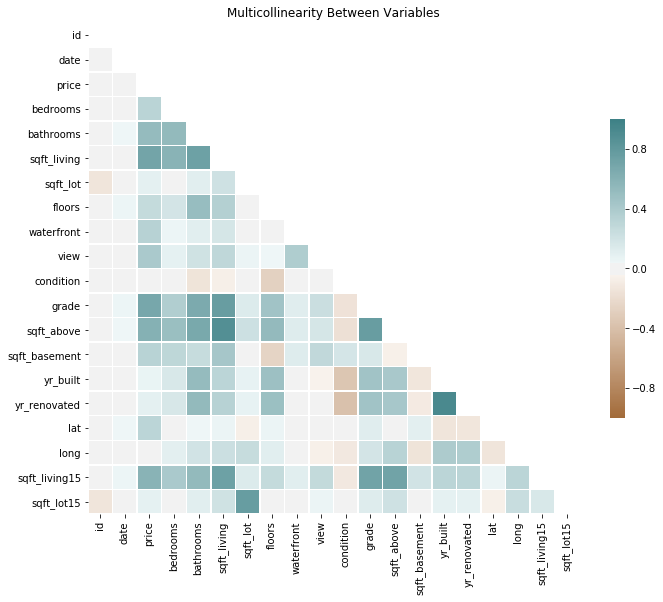

In [130]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(400, 200, as_cmap=True)
ax.set_title('Multicollinearity Between Variables')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [131]:
df.corr()
abs(df.corr()) > 0.75
# Show all pairwise correlations above .75

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Results
*Using absolute correlation of >= .75 as the cutoff*

**Columns with high correlation:**
- sqft_living, sqft_above and grade
- sqft_lot and sqft_lot15
- yr_built and year_renovated

We'll drop grade because it is the most subjective of the three. Because sqft_living is sqft_above + sqft_basement and sqft_basement, we're going to drop the sqft_living. This will give us more granularity in our predictors while still eliminating our multicollinearity problem.

This makes sense that a neighborhood would have similar lot sizes. We'll drop sqft_lot15 because it's the column that isn't specifically about the property in question.

This likely is caused by the way I chose to to handle the zeros in the yr_renovated column. Since these columns are highly correlated, we'll drop yr_renovated since it's the transfored column.

Drop ID because it's an aribitrary identification number for a house

**DROP:**
- id
- grade
- sqft_living
- sqft_lot15
- yr_renovated

In [132]:
df.drop(['id', 'grade', 'sqft_living', 'sqft_lot15', 'yr_renovated'], axis=1, inplace=True)
df.describe()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15
count,3755.000000,3.755000e+03,3755.000000,3755.000000,3.755000e+03,3755.000000,3755.000000,3755.000000,3755.000000,3755.00000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,1575.112916,5.399681e+05,3.366977,2.130959,1.540888e+04,1.509987,0.005326,0.213316,3.396804,1804.23249,284.206125,1971.766977,47.562675,-122.210337,1981.651931
std,113.381676,3.542885e+05,0.901119,0.773803,4.232521e+04,0.538446,0.072796,0.732482,0.648912,831.99125,442.868912,29.381101,0.138351,0.144104,682.031599
min,1368.000000,8.300000e+04,1.000000,0.750000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,470.00000,0.000000,1900.000000,47.164700,-122.515000,720.000000
25%,1464.000000,3.177500e+05,3.000000,1.750000,5.130000e+03,1.000000,0.000000,0.000000,3.000000,1190.00000,0.000000,1952.000000,47.473100,-122.326000,1490.000000
50%,1587.000000,4.550000e+05,3.000000,2.250000,7.625000e+03,1.500000,0.000000,0.000000,3.000000,1560.00000,0.000000,1977.000000,47.577600,-122.225000,1830.000000
75%,1678.000000,6.500000e+05,4.000000,2.500000,1.065800e+04,2.000000,0.000000,0.000000,4.000000,2260.00000,540.000000,1997.000000,47.680400,-122.121500,2360.000000
max,1755.000000,4.500000e+06,9.000000,7.500000,1.024068e+06,3.500000,1.000000,4.000000,5.000000,7320.00000,3500.000000,2015.000000,47.777600,-121.315000,5790.000000


### 5. Normalize Data
**Question:** *Are all of the features normally distributed?*

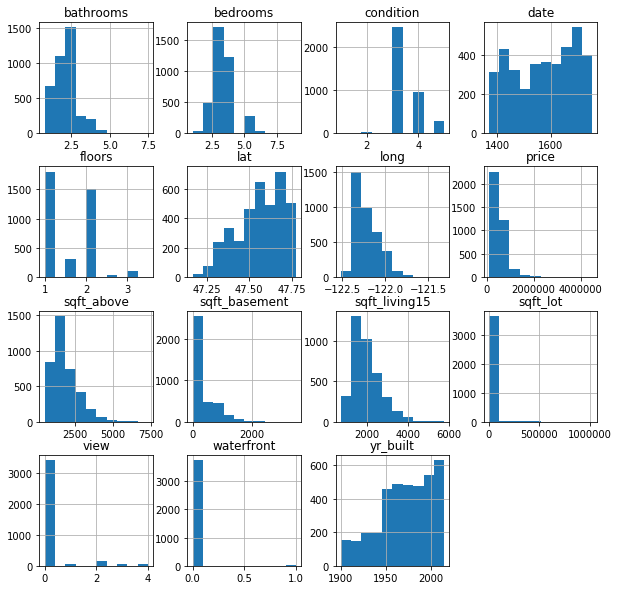

In [133]:
df.hist(figsize=(10,10))
plt.show()

Looks like most of the featrues are skewed. We'll need to log transform all numeric columns. 

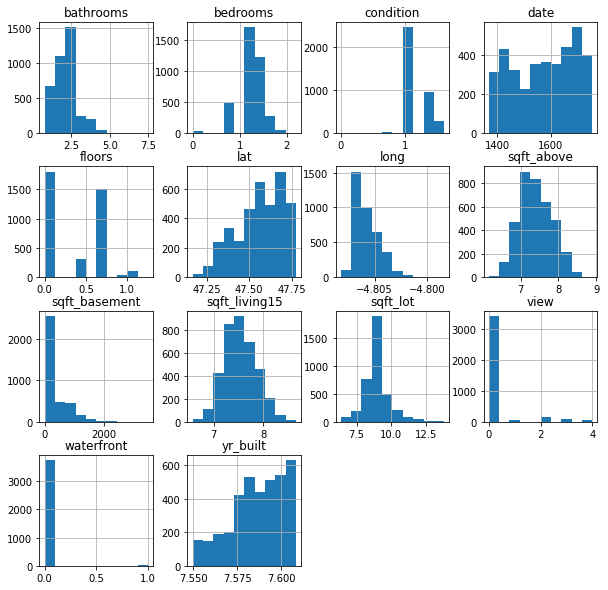

In [134]:
import scipy.stats as stats
ind_vars = df
dep_var = df['price']
ind_vars.drop(['price'], axis=1, inplace=True)
log_transformed = [] # Keep track of which variables were log transformed

for column in df.select_dtypes(include=['int64', 'float64']):
    # We want to log all columns that show signs of skewness
    if stats.skew(df[column]) >= 0.5 or stats.skew(df[column]) <= -0.5:
        """
        Can't log negative numbers. 
        All of of longitudes are negative, so we have to log the absolute value and then multiply by -1.
        """
        if column == 'long':
            ind_vars[column] = np.log(abs(df[column])) 
            ind_vars[column] = df[column] * -1 # Store in our independent variables df
            log_transformed.append(column)
            continue
        elif not df[column].isin([0]).any():
            ind_vars[column] = np.log(df[column]) # Store in our independent variables df
            log_transformed.append(column)
    else:
        ind_vars[column] = df[column] # add any now skewed columns to ind_vars without log

for column in df.select_dtypes(include=['category', 'object']):
    ind_vars[column] = df[column]

ind_vars.hist(figsize=(10,10))
plt.show()

While there is plenty of skewness left in the data, most of the features are looking much more normal. 

In [135]:
# Standardize numeric columns
for column in df.select_dtypes(include=['int64', 'float64']):
    if column != 'price':
        ind_vars[column] = (df[column] - df[column].mean()) / df[column].std()
ind_vars.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15
6035,-0.195031,0.741527,2.415396,0.545758,0.974857,-0.073166,2.439219,-0.584102,2.545379,2.587208,0.957580,98033,0.622510,0.064167,0.486975
12871,-0.247949,0.741527,0.799998,1.277773,0.974857,-0.073166,-0.291223,-0.584102,2.225166,-0.641739,0.823787,98004,0.234367,0.029487,2.210737
21099,-0.415525,0.741527,0.476919,-0.533776,0.974857,-0.073166,-0.291223,-0.584102,0.401484,-0.641739,1.357358,98065,-0.344596,2.349183,1.126219
11629,-1.094647,-1.705584,-0.815399,-0.078602,-0.991727,-0.073166,1.073998,-0.584102,-0.827205,-0.641739,-0.940342,98125,1.207977,-0.525187,0.053576
19536,-0.053914,0.741527,-0.492320,0.174696,-0.991727,-0.073166,-0.291223,0.984322,-0.255983,0.374363,-0.188289,98006,0.040656,0.230647,-0.094412


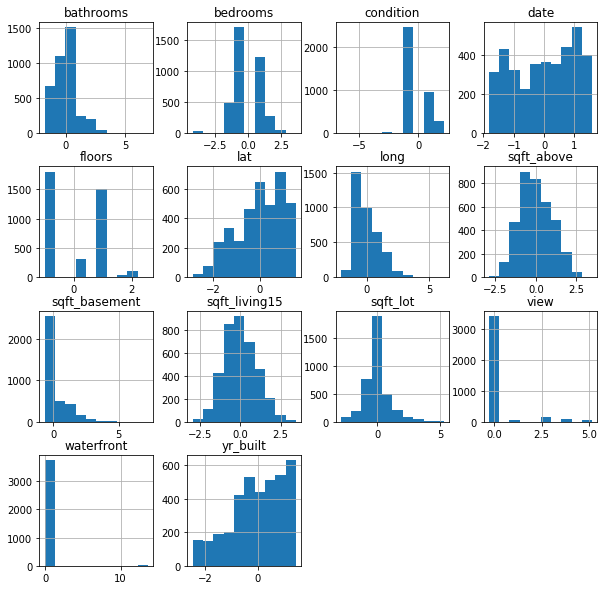

In [136]:
ind_vars.hist(figsize=(10,10))
plt.show()

## Explore
1. Understand the Data
2. Deriving Statistics
3. Creating visualizations

### 1. Understand the Data

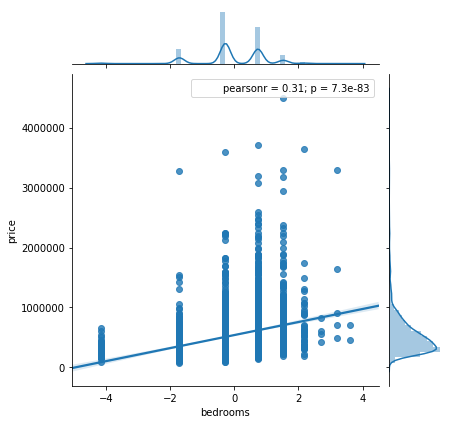

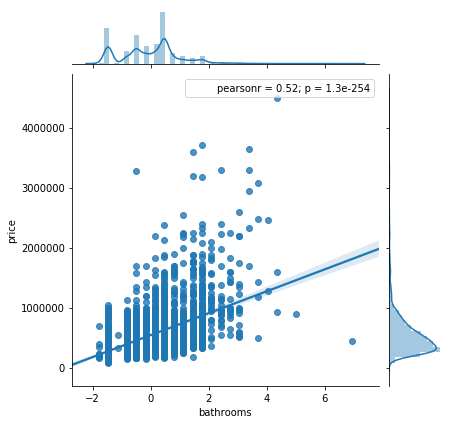

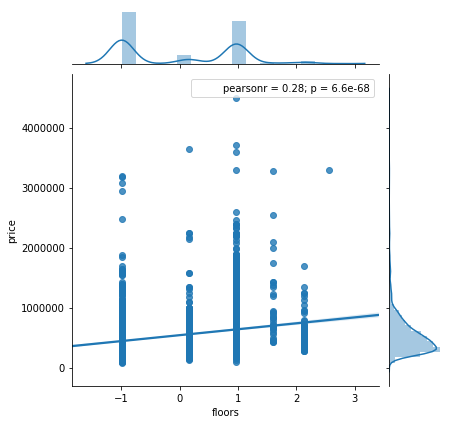

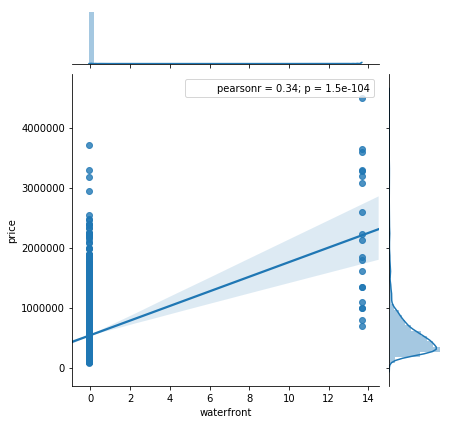

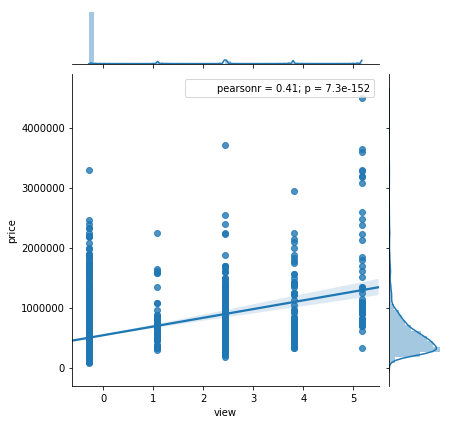

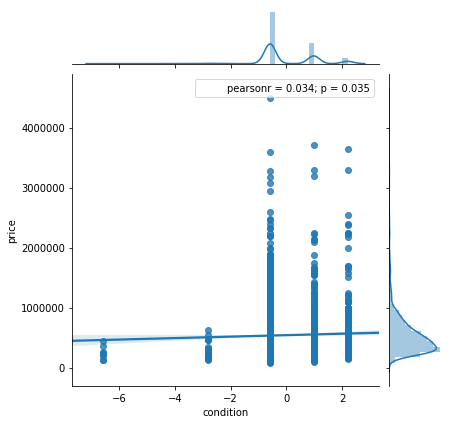

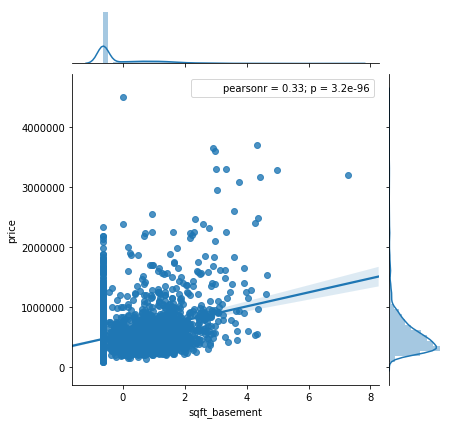

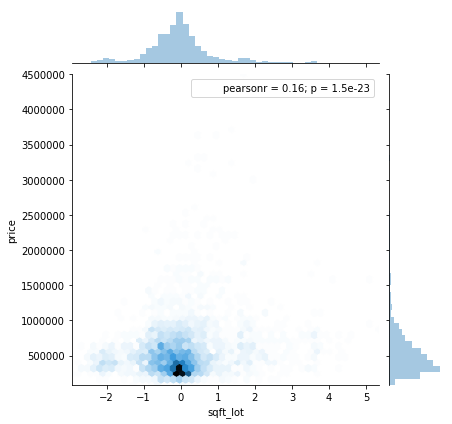

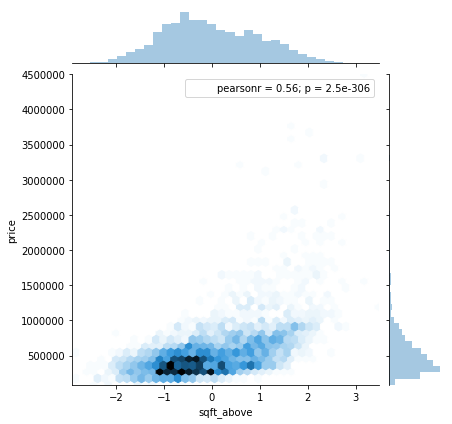

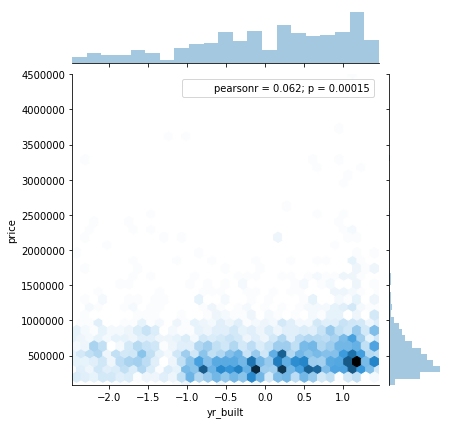

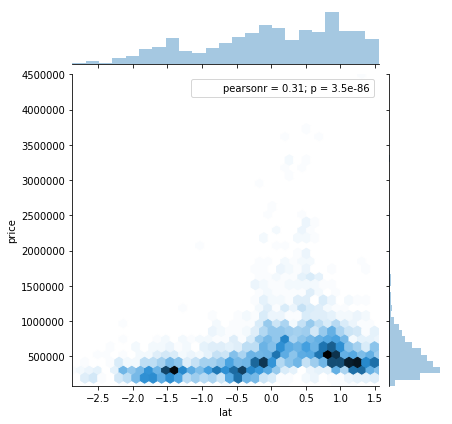

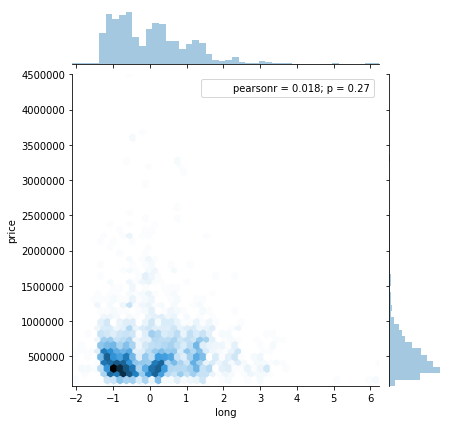

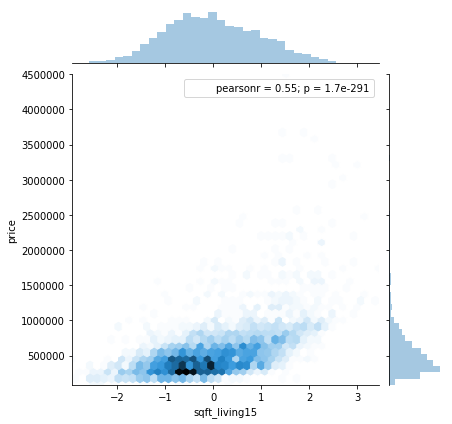

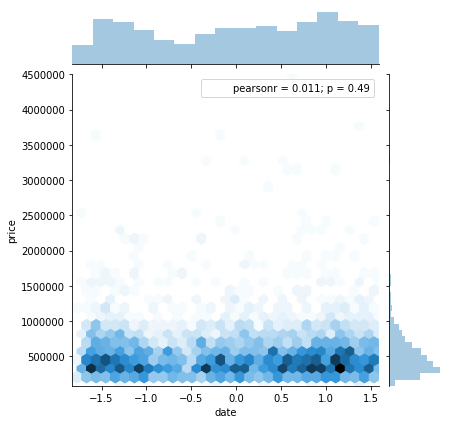

In [137]:
for column in list(ind_vars.select_dtypes(include=['int64', 'float64'])):
    if column not in ['sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
        sns.jointplot(x=ind_vars[column], y=dep_var, kind='reg')
for column in ['sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
    sns.jointplot(x=ind_vars[column], y=dep_var, kind='hex')

In [138]:
ind_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 6035 to 6142
Data columns (total 15 columns):
date             3755 non-null float64
bedrooms         3755 non-null float64
bathrooms        3755 non-null float64
sqft_lot         3755 non-null float64
floors           3755 non-null float64
waterfront       3755 non-null float64
view             3755 non-null float64
condition        3755 non-null float64
sqft_above       3755 non-null float64
sqft_basement    3755 non-null float64
yr_built         3755 non-null float64
zipcode          3755 non-null category
lat              3755 non-null float64
long             3755 non-null float64
sqft_living15    3755 non-null float64
dtypes: category(1), float64(14)
memory usage: 606.8 KB


## 4. Model
1. One - Hot - Encoding
2. Clustering
3. Classification
4. Regression
    - Assess the parameters (slopes, intercept) of the fitted model.
    - Check if the model explain much variation in data? (RMSE, F and R2)
    - Check if the estimates are significant in terms of testing your hypothesis?
    - Interpret the model coefficients, slopes and intercepts using appropriate units?
    - Check the impact of collinearity? Can you ignore it?
5. Dimensionality Reduction


In [139]:
# 1. One Hot Encoding
ind_vars = pd.get_dummies(ind_vars)
# ind_vars.head()
# ind_vars.columns.values
ind_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 6035 to 6142
Data columns (total 84 columns):
date             3755 non-null float64
bedrooms         3755 non-null float64
bathrooms        3755 non-null float64
sqft_lot         3755 non-null float64
floors           3755 non-null float64
waterfront       3755 non-null float64
view             3755 non-null float64
condition        3755 non-null float64
sqft_above       3755 non-null float64
sqft_basement    3755 non-null float64
yr_built         3755 non-null float64
lat              3755 non-null float64
long             3755 non-null float64
sqft_living15    3755 non-null float64
zipcode_98001    3755 non-null uint8
zipcode_98002    3755 non-null uint8
zipcode_98003    3755 non-null uint8
zipcode_98004    3755 non-null uint8
zipcode_98005    3755 non-null uint8
zipcode_98006    3755 non-null uint8
zipcode_98007    3755 non-null uint8
zipcode_98008    3755 non-null uint8
zipcode_98010    3755 non-null uint8
zipcode_980

In [140]:
ind_vars.to_csv('ind_vars_scrubbed.csv')
dep_var.to_csv('dep_var_scrubbed.csv')

In [141]:
X = ind_vars
y = dep_var
y_log = np.log(y)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     175.7
Date:                Wed, 20 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:54:37   Log-Likelihood:                -50298.
No. Observations:                3755   AIC:                         1.008e+05
Df Residuals:                    3671   BIC:                         1.013e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.396e+05   3309.559    163.031      0.000    5.33e+05    5.46e+05
date          -1.054e+04   2657.749     -3.967      0.000   -1.58e+04   -5333.597
bedrooms      -3.449e+04   3576.262     -9.643      0.000   -4.15e+04   -2.75e+04
bathrooms      2.996e+04   4725.450      6.340      0.000    2.07e+04    3.92e+04
sqft_lot       3.141e+04   4003.715      7.845      0.000    2.36e+04    3.93e+04
floors        -1.033e+04   4380.137     -2.358      0.018   -1.89e+04   -1739.208
waterfront     7.531e+04   2886.015     26.096      0.000    6.97e+04     8.1e+04
view           4.454e+04   3164.309     14.075      0.000    3.83e+04    5.07e+04
condition      1.974e+04   2952.687      6.684      0.000    1.39e+04    2.55e+04
sqft_above     1.603e+05   5814.851     27.561      0.000    1.49e+05    1.72e+05
sqft_basement  5.403e+04   3657.999     14.769      0.000    4.69e+04    6.12e+04
yr_built       -287.5100   4143.877     -0.069      0.945   -8412.038    7837.018
lat            5728.2622   2.14e+04      0.268      0.789   -3.62e+04    4.76e+04
long          -8110.6388   1.39e+04     -0.585      0.558   -3.53e+04     1.9e+04
sqft_living15  2.778e+04   4406.406      6.305      0.000    1.91e+04    3.64e+04
zipcode_98001 -2.252e+05    4.3e+04     -5.241      0.000   -3.09e+05   -1.41e+05
zipcode_98002 -1.658e+05    4.6e+04     -3.602      0.000   -2.56e+05   -7.56e+04
zipcode_98003 -2.068e+05   4.44e+04     -4.656      0.000   -2.94e+05    -1.2e+05
zipcode_98004  6.119e+05   2.35e+04     26.023      0.000    5.66e+05    6.58e+05
zipcode_98005  1.009e+05   3.06e+04      3.301      0.001     4.1e+04    1.61e+05
zipcode_98006  9.757e+04   1.91e+04      5.108      0.000    6.01e+04    1.35e+05
zipcode_98007  5.561e+04   3.56e+04      1.562      0.118   -1.42e+04    1.25e+05
zipcode_98008  7.739e+04   2.77e+04      2.798      0.005    2.32e+04    1.32e+05
zipcode_98010 -1.162e+05   5.25e+04     -2.214      0.027   -2.19e+05   -1.33e+04
zipcode_98011 -1.018e+05   4.12e+04     -2.472      0.013   -1.82e+05   -2.11e+04
zipcode_98014 -1.011e+05   4.97e+04     -2.036      0.042   -1.98e+05   -3722.134
zipcode_98019 -1.635e+05   4.76e+04     -3.435      0.001   -2.57e+05   -7.02e+04
zipcode_98022  -2.26e+05   6.27e+04     -3.607      0.000   -3.49e+05   -1.03e+05
zipcode_98023 -2.314e+05   4.51e+04     -5.135      0.000    -3.2e+05   -1.43e+05
zipcode_98024 -1.779e+04   4.93e+04     -0.361      0.718   -1.14e+05    7.89e+04
zipcode_98027  -4.37e+04    2.6e+04     -1.679      0.093   -9.47e+04    7343.223
zipcode_98028 -1.168e+05   3.95e+04     -2.955      0.003   -1.94e+05   -3.93e+04
zipcode_98029  6.603e+04   2.86e+04      2.306      0.021    9900.190    1.22e+05
zipcode_98030  -2.17e+05    3.7e+04     -5.863      0.000    -2.9e+05   -1.44e+05
zipcode_98031   -1.9e+05   3.24e+04     -5.865   

In [142]:
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     303.7
Date:                Wed, 20 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:54:37   Log-Likelihood:                 949.33
No. Observations:                3755   AIC:                            -1731.
Df Residuals:                    3671   BIC:                            -1207.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8641      0.004   3286.266      0.000      12.856      12.872
date             -0.0248      0.003     -7.895      0.000      -0.031      -0.019
bedrooms         -0.0210      0.004     -4.961      0.000      -0.029      -0.013
bathrooms         0.0317      0.006      5.664      0.000       0.021       0.043
sqft_lot          0.0614      0.005     12.969      0.000       0.052       0.071
floors           -0.0106      0.005     -2.040      0.041      -0.021      -0.000
waterfront        0.0382      0.003     11.183      0.000       0.031       0.045
view              0.0445      0.004     11.902      0.000       0.037       0.052
condition         0.0434      0.003     12.416      0.000       0.037       0.050
sqft_above        0.2307      0.007     33.536      0.000       0.217       0.244
sqft_basement     0.0639      0.004     14.758      0.000       0.055       0.072
yr_built          0.0243      0.005      4.950      0.000       0.015       0.034
lat               0.0451      0.025      1.784      0.075      -0.004       0.095
long             -0.0661      0.016     -4.031      0.000      -0.098      -0.034
sqft_living15     0.0739      0.005     14.179      0.000       0.064       0.084
zipcode_98001    -0.3076      0.051     -6.052      0.000      -0.407      -0.208
zipcode_98002    -0.2615      0.054     -4.803      0.000      -0.368      -0.155
zipcode_98003    -0.2606      0.053     -4.960      0.000      -0.364      -0.158
zipcode_98004     0.8462      0.028     30.429      0.000       0.792       0.901
zipcode_98005     0.4242      0.036     11.728      0.000       0.353       0.495
zipcode_98006     0.3945      0.023     17.464      0.000       0.350       0.439
zipcode_98007     0.3898      0.042      9.258      0.000       0.307       0.472
zipcode_98008     0.3774      0.033     11.537      0.000       0.313       0.442
zipcode_98010     0.0187      0.062      0.302      0.763      -0.103       0.140
zipcode_98011     0.0595      0.049      1.222      0.222      -0.036       0.155
zipcode_98014     0.0850      0.059      1.447      0.148      -0.030       0.200
zipcode_98019    -0.0307      0.056     -0.545      0.586      -0.141       0.080
zipcode_98022    -0.1285      0.074     -1.734      0.083      -0.274       0.017
zipcode_98023    -0.3337      0.053     -6.261      0.000      -0.438      -0.229
zipcode_98024     0.2866      0.058      4.915      0.000       0.172       0.401
zipcode_98027     0.2473      0.031      8.032      0.000       0.187       0.308
zipcode_98028    -0.0264      0.047     -0.564      0.572      -0.118       0.065
zipcode_98029     0.4270      0.034     12.610      0.000       0.361       0.493
zipcode_98030    -0.2663      0.044     -6.084      0.000      -0.352      -0.181
zipcode_98031    -0.1905      0.038     -4.970   

| Dep Var     | price | log_price |
|-------------|-------|-----------|
| R-sq        | 0.799 | 0.873     |
| Adj. R-sq   | 0.794 | 0.870     |
| F-statistic | 175.7 | 303.7     |

- It looks like our log transformed dependent variable allows us to have much more predictive power in our model, so we'll stick with that as our DV.
- drop any continuous variables that have a r-sq < 0.01
- drop one column of any categorical variables

In [143]:
data = X.join(y_log)
for var in ind_vars.select_dtypes(include=['int64', 'float64']):
    formula = 'price~' + var
    print(formula)
    model = smf.ols(formula=formula, data=data)
    reg = model.fit()
    print('r-sq: ', reg.rsquared)
    if reg.rsquared < 0.01:
        X.drop(var, axis=1, inplace=True)
        print('dropped')
    print('-------------------------')

X.drop('zipcode_98199', axis=1, inplace=True)

price~date
r-sq:  0.000105030140257
dropped
-------------------------
price~bedrooms
r-sq:  0.123845966591
-------------------------
price~bathrooms
r-sq:  0.296397866919
-------------------------
price~sqft_lot
r-sq:  0.0209713196113
-------------------------
price~floors
r-sq:  0.110521782948
-------------------------
price~waterfront
r-sq:  0.0386431965868
-------------------------
price~view
r-sq:  0.114549539275
-------------------------
price~condition
r-sq:  0.00092984172643
dropped
-------------------------
price~sqft_above
r-sq:  0.359144079047
-------------------------
price~sqft_basement
r-sq:  0.0926419934024
-------------------------
price~yr_built
r-sq:  0.00849482128386
dropped
-------------------------
price~lat
r-sq:  0.201064102702
-------------------------
price~long
r-sq:  0.0012451311974
dropped
-------------------------
price~sqft_living15
r-sq:  0.35755616179
-------------------------


In [144]:
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     298.1
Date:                Wed, 20 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:54:55   Log-Likelihood:                 836.44
No. Observations:                3755   AIC:                            -1513.
Df Residuals:                    3675   BIC:                            -1014.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4591      0.029    457.063      0.000      13.401      13.517
bedrooms         -0.0194      0.004     -4.491      0.000      -0.028      -0.011
bathrooms         0.0375      0.005      6.931      0.000       0.027       0.048
sqft_lot          0.0563      0.005     11.986      0.000       0.047       0.066
floors           -0.0143      0.005     -2.755      0.006      -0.024      -0.004
waterfront        0.0383      0.004     10.911      0.000       0.031       0.045
view              0.0441      0.004     11.453      0.000       0.037       0.052
sqft_above        0.2322      0.007     32.791      0.000       0.218       0.246
sqft_basement     0.0685      0.004     15.447      0.000       0.060       0.077
lat               0.0554      0.026      2.129      0.033       0.004       0.106
sqft_living15     0.0699      0.005     13.103      0.000       0.059       0.080
zipcode_98001    -0.8495      0.072    -11.809      0.000      -0.991      -0.708
zipcode_98002    -0.8041      0.075    -10.672      0.000      -0.952      -0.656
zipcode_98003    -0.7849      0.073    -10.803      0.000      -0.927      -0.642
zipcode_98004     0.2507      0.037      6.866      0.000       0.179       0.322
zipcode_98005    -0.1757      0.044     -3.997      0.000      -0.262      -0.090
zipcode_98006    -0.2078      0.037     -5.606      0.000      -0.280      -0.135
zipcode_98007    -0.2325      0.049     -4.717      0.000      -0.329      -0.136
zipcode_98008    -0.2419      0.039     -6.175      0.000      -0.319      -0.165
zipcode_98010    -0.6121      0.077     -7.904      0.000      -0.764      -0.460
zipcode_98011    -0.5541      0.046    -12.063      0.000      -0.644      -0.464
zipcode_98014    -0.6767      0.044    -15.390      0.000      -0.763      -0.590
zipcode_98019    -0.7713      0.046    -16.937      0.000      -0.861      -0.682
zipcode_98022    -0.7725      0.092     -8.399      0.000      -0.953      -0.592
zipcode_98023    -0.8266      0.072    -11.499      0.000      -0.968      -0.686
zipcode_98024    -0.4378      0.059     -7.429      0.000      -0.553      -0.322
zipcode_98027    -0.4128      0.042     -9.733      0.000      -0.496      -0.330
zipcode_98028    -0.6132      0.044    -13.996      0.000      -0.699      -0.527
zipcode_98029    -0.2610      0.039     -6.699      0.000      -0.337      -0.185
zipcode_98030    -0.8471      0.065    -13.095      0.000      -0.974      -0.720
zipcode_98031    -0.7635      0.059    -12.968      0.000      -0.879      -0.648
zipcode_98032    -0.8249      0.071    -11.691      0.000      -0.963      -0.687
zipcode_98033    -0.1497      0.035     -4.338      0.000      -0.217      -0.082
zipcode_98034    -0.4313      0.035    -12.388      0.000      -0.500      -0.363
zipcode_98038    -0.6975      0.061    -11.382   